In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import os
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import stats
from scipy.stats import skew, norm
from scipy.stats import boxcox_normmax
from sklearn.cluster import KMeans
import scipy.spatial.distance as dist
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [2]:
import pandas as pd
store = pd.read_csv('../data/store.csv')
train_data = pd.read_csv('../data/train_data.csv')

C:\Users\user\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
train_data.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,month,day_of_month
0,1,5,2015-07-31,5263.0,555.0,1,1,0,1,c,a,1270.0,9.0,2008.0,0,unknown,unknown,unknown,7,31
1,2,5,2015-07-31,6064.0,625.0,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",7,31
2,3,5,2015-07-31,8314.0,821.0,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",7,31
3,4,5,2015-07-31,13995.0,609.0,1,1,0,1,c,c,620.0,9.0,2009.0,0,unknown,unknown,unknown,7,31
4,5,5,2015-07-31,4822.0,559.0,1,1,0,1,a,a,2330.0,4.0,2015.0,0,unknown,unknown,unknown,7,31


In [4]:
season = train_data.filter(['Date', 'Sales'], axis=1)
season.head()

,Date,Sales
0,2015-07-31,5263.0
1,2015-07-31,6064.0
2,2015-07-31,8314.0
3,2015-07-31,13995.0
4,2015-07-31,4822.0


In [5]:
season['Date'] = season['Date'].astype('datetime64')

<h3>Promotion Distribution</h3>

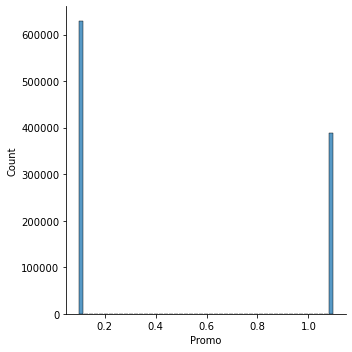

In [6]:
sns.displot(train_data, x="Promo", shrink=.8)

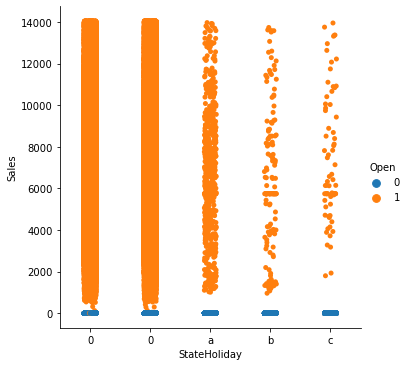

In [7]:
sns.catplot(x="StateHoliday", hue="Open", data=train_data, y="Sales")

<p>a = public holiday, b = Easter holiday, c = Christmas, 0 = None
There are more sales during public holidays and least sales is experienced during Cristmas holidays

<h3>What can you say about the correlation between sales and number of customers? 

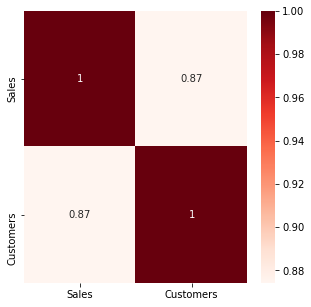

In [8]:
#Using Pearson Correlation
sales_cust = train_data[['Sales','Customers']]
plt.figure(figsize=(5,5))
cor = sales_cust.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

<p>There is a high correlation between sales and number of customers

In [9]:
stateholiday = train_data.filter(['StateHoliday', 'Sales'], axis=1)
stateholiday.head()

,StateHoliday,Sales
0,0,5263.0
1,0,6064.0
2,0,8314.0
3,0,13995.0
4,0,4822.0


In [10]:
stateholiday_sales = stateholiday.groupby(['StateHoliday']).agg({'Sales': ['mean','sum']})
stateholiday_sales.columns = ['Mean','Total']
stateholiday_sales = stateholiday_sales.reset_index()
stateholiday_sales

,StateHoliday,Mean,Total
0,0,5610.070600,2.205970e+09
1,0,5658.228766,3.355007e+09
2,a,227.222211,4.603522e+06
3,b,138.526906,9.267450e+05
4,c,129.639024,5.315200e+05


<function matplotlib.pyplot.show(close=None, block=None)>

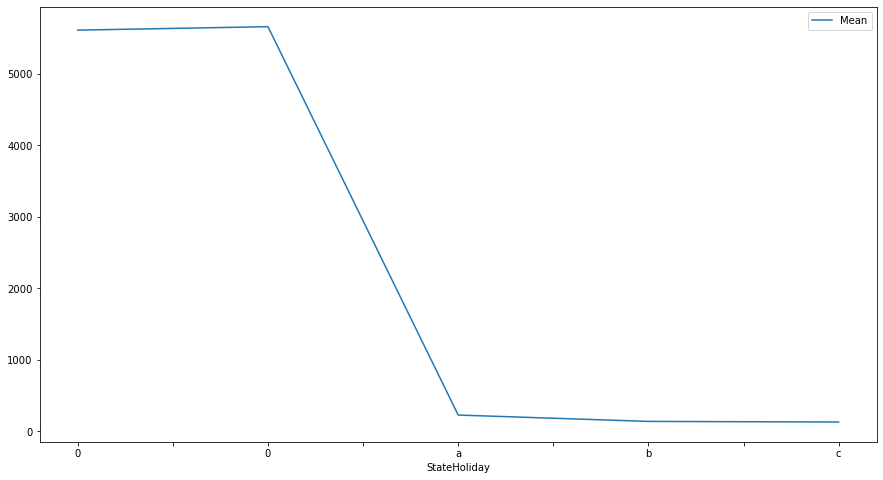

In [11]:
stateholiday_sales.plot('StateHoliday', 'Mean', figsize=(15,8))
plt.show

        Total Sales  Total Customers
Promo                               
0      2.685396e+09      299670992.0
1      2.881643e+09      288631133.0


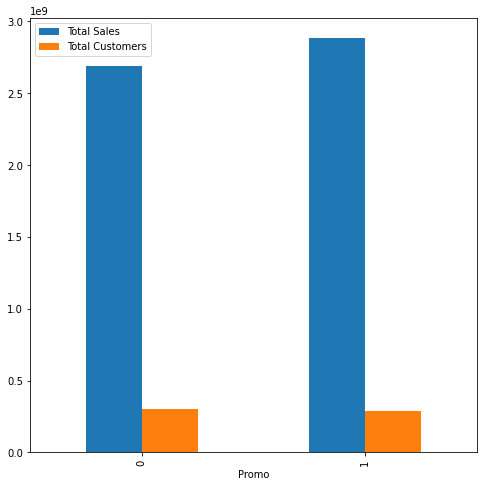

In [12]:
promotion_data = train_data.filter(['Sales', 'Customers', 'Promo'], axis=1)
promotion_data = promotion_data.groupby(['Promo']).agg({'Sales':['sum'], 'Customers':['sum']})
promotion_data.columns = ['Total Sales', 'Total Customers']
promotion_data = promotion_data.reset_index()
promotion_data.set_index('Promo', inplace=True, drop=True)

print(promotion_data)
promotion_data.plot.bar(figsize=(8,8))
plt.show()

<h3>Trends of customer behavior during store open and closing times

In [13]:
customer_behaviour = train_data.groupby('Open').agg({'Customers':'sum','Sales':'sum'})
customer_behaviour.head()

,Customers,Sales
Open,,
0,0.0,0.000000e+00
1,588302125.0,5.567038e+09


<h3>Which stores are opened on all weekdays? How does that affect their sales on weekends? 

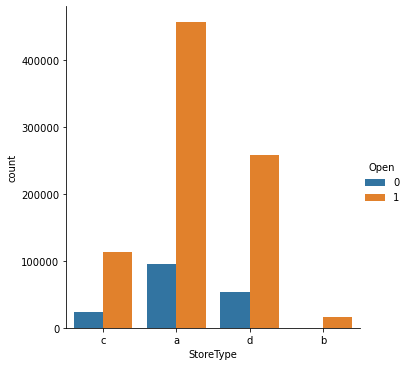

In [17]:
sns.catplot(x="StoreType", hue="Open", data=train_data, kind="count")

In [15]:
train_data.groupby(['StoreType', 'Open', 'DayOfWeek'])['DayOfWeek'].count().unstack().head(30)

DayOfWeek             1        2        3        4        5        6        7
StoreType Open                                                               
a         0      3881.0    890.0   2009.0   6060.0   3956.0    370.0  77384.0
          1     74603.0  78111.0  76993.0  73026.0  75130.0  78114.0   1100.0
b         0        37.0     40.0     40.0     39.0     38.0     37.0     36.0
          1      2215.0   2228.0   2228.0   2230.0   2231.0   2215.0   2216.0
c         0      1010.0    259.0    549.0   1473.0   1003.0    100.0  19468.0
          1     18458.0  19343.0  19053.0  18143.0  18613.0  19368.0      NaN
d         0      2242.0    514.0   1131.0   3629.0   2208.0    165.0  44249.0
          1     42284.0  44279.0  43662.0  41245.0  42666.0  44361.0    277.0